### ***`Imports`***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras import layers
from matplotlib import rcParams
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category= ConvergenceWarning)

TrainDF = pd.read_csv("train.csv")

### ***`Presenting Data`***

In [2]:
TrainDF.head()

,Unnamed: 0,id,owner_1_score,RATE_owner_1,CAP_AMOUNT_owner_1,PERCENT_OWN_owner_1,owner_2_score,RATE_owner_2,CAP_AMOUNT_owner_2,PERCENT_OWN_owner_2,...,INPUT_VALUE_ID_FOR_avg_net_deposits,RATE_ID_FOR_avg_net_deposits,INPUT_VALUE_ID_FOR_industry_type,RATE_ID_FOR_industry_type,INPUT_VALUE_owner_4,RATE_owner_4,CAP_AMOUNT_owner_4,PERCENT_OWN_owner_4,deal_application_thread_id,completion_status
0,900,4813,606.0,A,150000.0,100.0,NaN,NaN,NaN,NaN,...,0.00,NaN,preferred,NaN,606.0,A,150000.0,100.0,4642.0,Paid off with renewal
1,329,1406,703.0,A,150000.0,100.0,NaN,NaN,NaN,NaN,...,107027.25,NaN,preferred,NaN,703.0,A,150000.0,100.0,1362.0,Paid in full
2,1035,7415,692.0,A,150000.0,100.0,NaN,NaN,NaN,NaN,...,0.00,NaN,preferred,NaN,692.0,A,150000.0,100.0,6485.0,Default
3,1670,6759,684.0,A,150000.0,100.0,NaN,NaN,NaN,NaN,...,0.00,NaN,preferred,NaN,684.0,A,150000.0,100.0,6035.0,Paid via discounted payoff
4,1726,5867,625.0,A,150000.0,100.0,NaN,NaN,NaN,NaN,...,0.00,NaN,preferred,NaN,625.0,A,150000.0,100.0,5299.0,Paid in full


In [3]:
TrainDF.shape

(1810, 56)

In [4]:
TrainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                1810 non-null   int64  
 1   id                                        1810 non-null   int64  
 2   owner_1_score                             1786 non-null   float64
 3   RATE_owner_1                              1780 non-null   object 
 4   CAP_AMOUNT_owner_1                        1775 non-null   float64
 5   PERCENT_OWN_owner_1                       1793 non-null   float64
 6   owner_2_score                             214 non-null    float64
 7   RATE_owner_2                              214 non-null    object 
 8   CAP_AMOUNT_owner_2                        202 non-null    float64
 9   PERCENT_OWN_owner_2                       259 non-null    float64
 10  owner_3_score                       

In [5]:
dups = TrainDF.duplicated().sum()

print("Number of duplicated items: ", dups)

Number of duplicated items:  0


In [6]:
TrainDF.isna().sum()

Unnamed: 0                                     0
id                                             0
owner_1_score                                 24
RATE_owner_1                                  30
CAP_AMOUNT_owner_1                            35
PERCENT_OWN_owner_1                           17
owner_2_score                               1596
RATE_owner_2                                1596
CAP_AMOUNT_owner_2                          1608
PERCENT_OWN_owner_2                         1551
owner_3_score                               1800
RATE_owner_3                                1800
CAP_AMOUNT_owner_3                          1800
PERCENT_OWN_owner_3                         1768
years_in_business                             16
RATE_ID_FOR_years_in_business                 16
fsr                                          495
RATE_ID_FOR_fsr                             1791
location                                      11
RATE_ID_FOR_location                          74
funded_last_30      

In [7]:
type = TrainDF.dtypes # array of Data Types
column_lable = TrainDF.columns # array of Labels
C_len = len(column_lable) # array of Column Length

In [8]:
for i in range(C_len):
   nulls = TrainDF[column_lable[i]].isnull().sum()*100/TrainDF.shape[0]
   if nulls >= 100:
     print(column_lable[i].ljust(45), round(nulls, 2), "%")

INPUT_VALUE_ID_FOR_judgement_lien_time        100.0 %
RATE_ID_FOR_judgement_lien_time               100.0 %
RATE_ID_FOR_avg_net_deposits                  100.0 %
RATE_ID_FOR_industry_type                     100.0 %


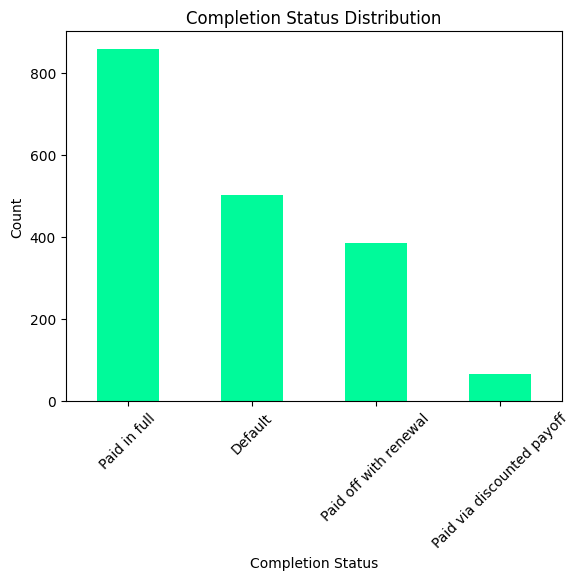

In [9]:
counts = TrainDF['completion_status'].value_counts()
ax = counts.plot(kind='bar', rot=45, color = 'mediumspringgreen')
ax.set_xlabel('Completion Status')
ax.set_ylabel('Count')
ax.set_title('Completion Status Distribution')
plt.show()

### ***`Pre-Processing`***

In [10]:
# Drop multiple columns
TrainDF.drop(['Unnamed: 0','id'], axis=1, inplace=True)

# Drop Columns because it has 100% nulls
TrainDF.drop(['INPUT_VALUE_ID_FOR_judgement_lien_time'], axis=1, inplace=True)
TrainDF.drop(['RATE_ID_FOR_avg_net_deposits'], axis=1, inplace=True)
TrainDF.drop(['RATE_ID_FOR_judgement_lien_time'], axis=1, inplace=True)
TrainDF.drop(['RATE_ID_FOR_industry_type'], axis=1, inplace=True)

Drops = {'INPUT_VALUE_ID_FOR_judgement_lien_time','RATE_ID_FOR_avg_net_deposits','RATE_ID_FOR_judgement_lien_time',
         'RATE_ID_FOR_industry_type','RATE_ID_FOR_funded_last_30','RATE_ID_FOR_fsr'}

##### Filling Nulls

In [11]:
# Object
TrainDF[['RATE_owner_1', 'RATE_owner_2', 'RATE_owner_3', 'RATE_ID_FOR_years_in_business', 'RATE_ID_FOR_fsr', 'location', 'RATE_ID_FOR_location', 'RATE_owner_4', 
'RATE_ID_FOR_location', 'RATE_ID_FOR_funded_last_30', 'RATE_ID_FOR_num_negative_days', 'RATE_ID_FOR_tax_lien_count', 'RATE_ID_FOR_current_position', 
'INPUT_VALUE_ID_FOR_industry_type']].describe()

,RATE_owner_1,RATE_owner_2,RATE_owner_3,RATE_ID_FOR_years_in_business,RATE_ID_FOR_fsr,location,RATE_ID_FOR_location,RATE_owner_4,RATE_ID_FOR_location,RATE_ID_FOR_funded_last_30,RATE_ID_FOR_num_negative_days,RATE_ID_FOR_tax_lien_count,RATE_ID_FOR_current_position,INPUT_VALUE_ID_FOR_industry_type
count,1780,214,10,1794,19,1799,1736,1731,1736,6,1808,1799,1796,1780
unique,5,5,2,4,2,4,1,5,1,1,4,2,3,4
top,A,A,A,A,D,Verified,A,A,A,D,A,A,A,preferred
freq,1071,137,7,1551,10,1115,1736,1034,1736,6,1526,1792,1490,1569


In [12]:
TrainDF.describe()

,owner_1_score,CAP_AMOUNT_owner_1,PERCENT_OWN_owner_1,owner_2_score,CAP_AMOUNT_owner_2,PERCENT_OWN_owner_2,owner_3_score,CAP_AMOUNT_owner_3,PERCENT_OWN_owner_3,years_in_business,...,INPUT_VALUE_ID_FOR_fc_margin,INPUT_VALUE_ID_FOR_tax_lien_amount,INPUT_VALUE_ID_FOR_tax_lien_percent,INPUT_VALUE_ID_FOR_tax_lien_count,INPUT_VALUE_ID_FOR_current_position,INPUT_VALUE_ID_FOR_avg_net_deposits,INPUT_VALUE_owner_4,CAP_AMOUNT_owner_4,PERCENT_OWN_owner_4,deal_application_thread_id
count,1786.000000,1775.000000,1793.000000,214.000000,202.000000,259.000000,10.000000,10.000000,42.000000,1794.000000,...,1810.000000,1810.000000,1810.000000,1799.000000,1796.000000,1.803000e+03,1777.000000,1714.000000,1755.00000,1810.000000
mean,641.054871,116921.126761,92.623424,1087.990654,114529.702970,35.180695,677.900000,105000.000000,8.328571,18.212653,...,0.113138,642.453729,0.041799,0.015564,0.714922,8.912347e+04,655.070906,116245.624271,97.13453,3961.659116
std,449.126835,47185.432359,37.182069,1934.812936,55576.146579,18.644552,203.136763,72456.883731,16.557369,127.405128,...,0.160443,20139.122402,1.279912,0.178929,0.781414,1.668000e+05,572.824248,47780.361911,35.10213,2156.725892
min,0.000000,0.000000,0.000000,432.000000,0.000000,0.000000,376.000000,0.000000,0.000000,0.030000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,88.000000
25%,573.000000,100000.000000,100.000000,560.000000,100000.000000,20.000000,500.250000,37500.000000,0.000000,3.060000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,568.000000,100000.000000,100.00000,2311.000000
50%,620.000000,150000.000000,100.000000,647.000000,150000.000000,49.000000,804.000000,150000.000000,0.000000,5.760000,...,0.070000,0.000000,0.000000,0.000000,1.000000,4.725129e+04,621.000000,150000.000000,100.00000,4196.500000
75%,663.000000,150000.000000,100.000000,679.000000,150000.000000,50.000000,804.000000,150000.000000,0.000000,11.370000,...,0.150000,0.000000,0.000000,0.000000,1.000000,1.036317e+05,664.000000,150000.000000,100.00000,5368.000000
max,9002.000000,150000.000000,1000.000000,9002.000000,150000.000000,64.000000,804.000000,150000.000000,50.000000,1805.400000,...,1.800000,847473.000000,53.968000,3.000000,4.000000,2.291481e+06,9002.000000,150000.000000,1000.00000,9062.000000


In [13]:
# Float
C1 = ['owner_1_score', 'owner_2_score', 'owner_3_score', 'CAP_AMOUNT_owner_1', 'CAP_AMOUNT_owner_2', 'CAP_AMOUNT_owner_3', 'PERCENT_OWN_owner_1', 'PERCENT_OWN_owner_2', 
      'PERCENT_OWN_owner_3', 'years_in_business', 'fsr', 'INPUT_VALUE_ID_FOR_tax_lien_count', 'INPUT_VALUE_ID_FOR_current_position', 'INPUT_VALUE_ID_FOR_avg_net_deposits', 
      'INPUT_VALUE_owner_4', 'CAP_AMOUNT_owner_4', 'PERCENT_OWN_owner_4']

for col1 in C1:
    TrainDF[col1].fillna(TrainDF[col1].mean(), inplace=True)

# Object
C2 = ['RATE_owner_1', 'RATE_owner_2', 'RATE_owner_3', 'RATE_ID_FOR_years_in_business', 'RATE_ID_FOR_location',
      'RATE_ID_FOR_num_negative_days', 'RATE_ID_FOR_tax_lien_count', 'RATE_ID_FOR_current_position', 'RATE_owner_4']

for col2 in C2:
    TrainDF[col2].fillna('A', inplace=True)

# Rest of Obj

TrainDF['RATE_ID_FOR_funded_last_30'].fillna('D', inplace=True)
TrainDF['RATE_ID_FOR_fsr'].fillna('D', inplace=True)

TrainDF['location'].fillna('Verified', inplace=True)
TrainDF['INPUT_VALUE_ID_FOR_industry_type'].fillna('preferred', inplace=True)


In [14]:
TrainDF.isna().sum()

owner_1_score                               0
RATE_owner_1                                0
CAP_AMOUNT_owner_1                          0
PERCENT_OWN_owner_1                         0
owner_2_score                               0
RATE_owner_2                                0
CAP_AMOUNT_owner_2                          0
PERCENT_OWN_owner_2                         0
owner_3_score                               0
RATE_owner_3                                0
CAP_AMOUNT_owner_3                          0
PERCENT_OWN_owner_3                         0
years_in_business                           0
RATE_ID_FOR_years_in_business               0
fsr                                         0
RATE_ID_FOR_fsr                             0
location                                    0
RATE_ID_FOR_location                        0
funded_last_30                              0
RATE_ID_FOR_funded_last_30                  0
judgement_lien_percent                      0
RATE_ID_FOR_judgement_lien_percent

In [15]:
TrainDF.head()

,owner_1_score,RATE_owner_1,CAP_AMOUNT_owner_1,PERCENT_OWN_owner_1,owner_2_score,RATE_owner_2,CAP_AMOUNT_owner_2,PERCENT_OWN_owner_2,owner_3_score,RATE_owner_3,...,INPUT_VALUE_ID_FOR_current_position,RATE_ID_FOR_current_position,INPUT_VALUE_ID_FOR_avg_net_deposits,INPUT_VALUE_ID_FOR_industry_type,INPUT_VALUE_owner_4,RATE_owner_4,CAP_AMOUNT_owner_4,PERCENT_OWN_owner_4,deal_application_thread_id,completion_status
0,606.0,A,150000.0,100.0,1087.990654,A,114529.70297,35.180695,677.9,A,...,0.0,A,0.00,preferred,606.0,A,150000.0,100.0,4642.0,Paid off with renewal
1,703.0,A,150000.0,100.0,1087.990654,A,114529.70297,35.180695,677.9,A,...,1.0,A,107027.25,preferred,703.0,A,150000.0,100.0,1362.0,Paid in full
2,692.0,A,150000.0,100.0,1087.990654,A,114529.70297,35.180695,677.9,A,...,0.0,A,0.00,preferred,692.0,A,150000.0,100.0,6485.0,Default
3,684.0,A,150000.0,100.0,1087.990654,A,114529.70297,35.180695,677.9,A,...,0.0,A,0.00,preferred,684.0,A,150000.0,100.0,6035.0,Paid via discounted payoff
4,625.0,A,150000.0,100.0,1087.990654,A,114529.70297,35.180695,677.9,A,...,0.0,A,0.00,preferred,625.0,A,150000.0,100.0,5299.0,Paid in full


##### Save Data to fill nulls

In [16]:
Train_mean = TrainDF.mean()
Train_mean

owner_1_score                                  641.054871
CAP_AMOUNT_owner_1                          116921.126761
PERCENT_OWN_owner_1                             92.623424
owner_2_score                                 1087.990654
CAP_AMOUNT_owner_2                          114529.702970
PERCENT_OWN_owner_2                             35.180695
owner_3_score                                  677.900000
CAP_AMOUNT_owner_3                          105000.000000
PERCENT_OWN_owner_3                              8.328571
years_in_business                               18.212653
fsr                                             39.800760
judgement_lien_percent                           0.528003
INPUT_VALUE_ID_FOR_judgement_lien_amount       673.691575
INPUT_VALUE_ID_FOR_num_negative_days             3.535258
INPUT_VALUE_ID_FOR_num_deposits                 25.680508
INPUT_VALUE_ID_FOR_monthly_gross             88602.555144
INPUT_VALUE_ID_FOR_average_ledger            15331.403608
INPUT_VALUE_ID

In [17]:
Train_cols = TrainDF.columns.tolist()
common_value = []
common_name = []
for col in TrainDF.columns:
    data_type = TrainDF[col].dtype
    if data_type == object:
        top_value = TrainDF[col].value_counts().index[0]
        common_name.append(col)
        common_value.append(top_value)

common_df = pd.DataFrame(columns=common_name)
common_df.loc[0] = common_value
common_df


,RATE_owner_1,RATE_owner_2,RATE_owner_3,RATE_ID_FOR_years_in_business,RATE_ID_FOR_fsr,location,RATE_ID_FOR_location,funded_last_30,RATE_ID_FOR_funded_last_30,RATE_ID_FOR_judgement_lien_percent,...,RATE_ID_FOR_monthly_gross,RATE_ID_FOR_average_ledger,RATE_ID_FOR_fc_margin,RATE_ID_FOR_tax_lien_amount,RATE_ID_FOR_tax_lien_percent,RATE_ID_FOR_tax_lien_count,RATE_ID_FOR_current_position,INPUT_VALUE_ID_FOR_industry_type,RATE_owner_4,completion_status
0,A,A,A,A,D,Verified,A,N,D,A,...,A,A,A,A,A,A,A,preferred,A,Paid in full


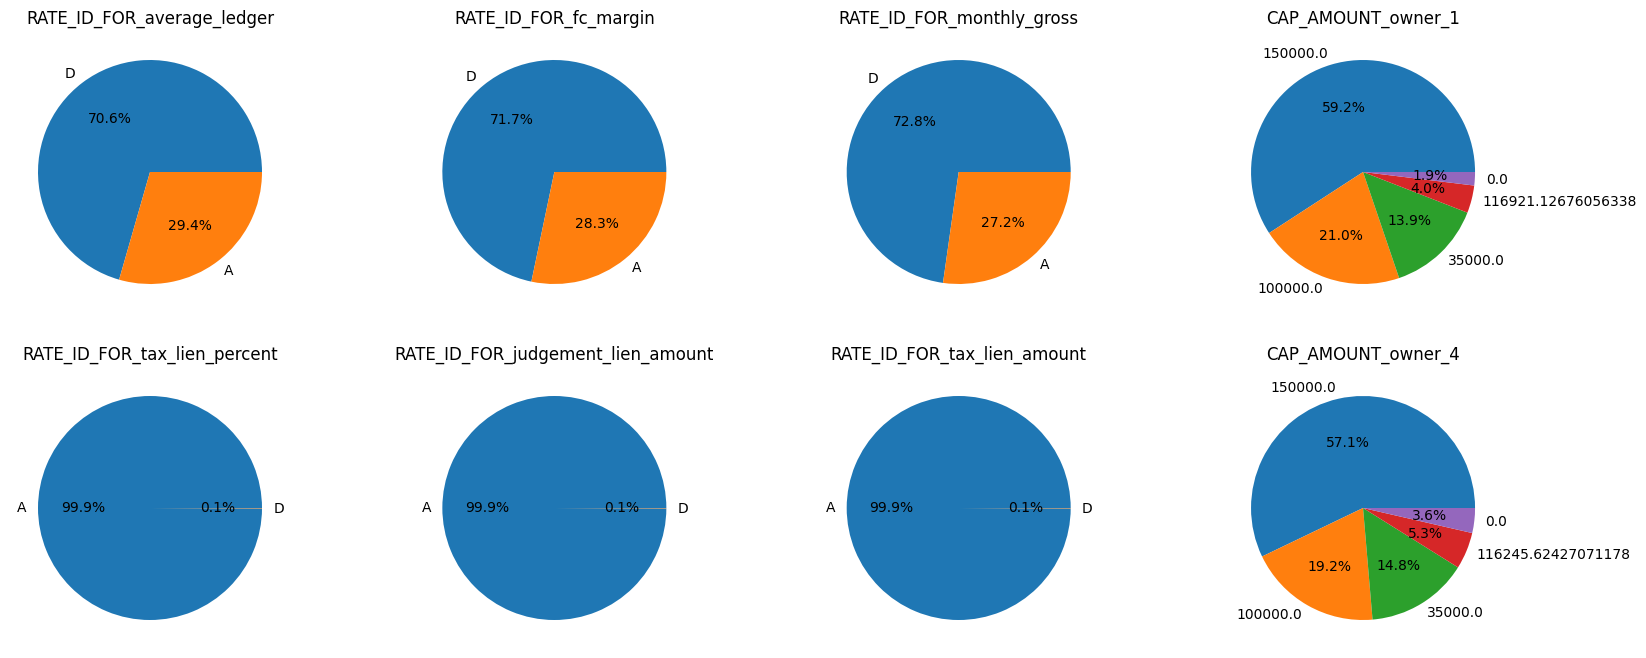

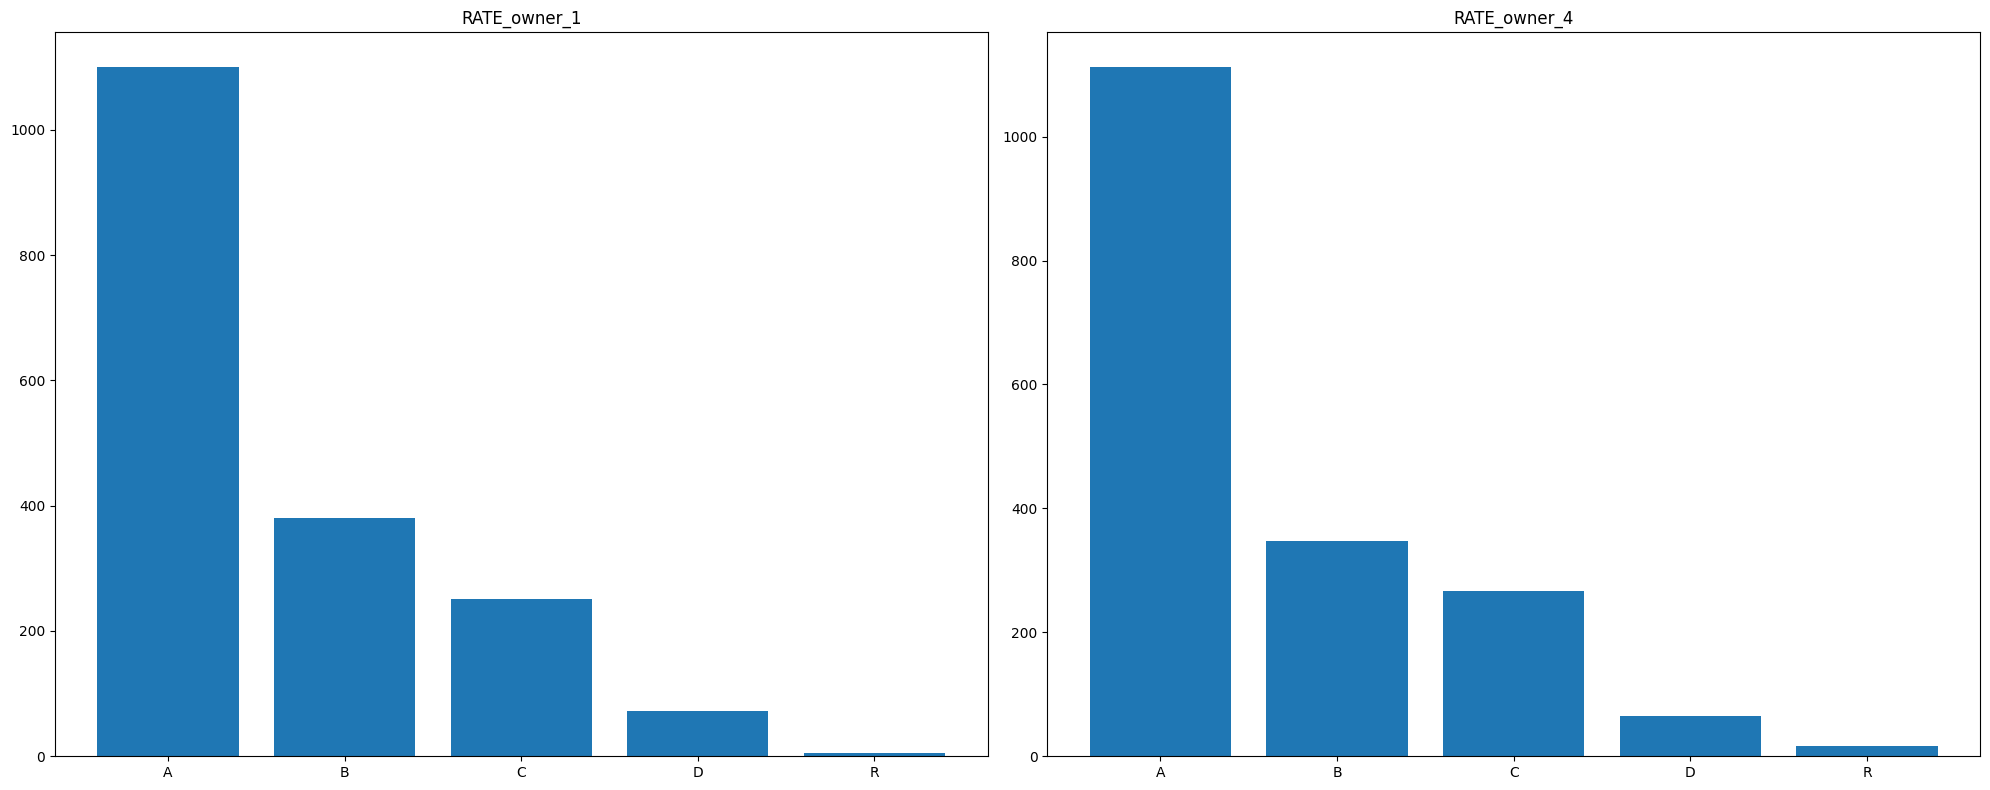

In [18]:
cols1 = ['RATE_ID_FOR_average_ledger', 'RATE_ID_FOR_fc_margin', 'RATE_ID_FOR_monthly_gross', 'CAP_AMOUNT_owner_1', 
         'RATE_ID_FOR_tax_lien_percent', 'RATE_ID_FOR_judgement_lien_amount', 'RATE_ID_FOR_tax_lien_amount', 'CAP_AMOUNT_owner_4']

cols2 = ['RATE_owner_1', 'RATE_owner_4']

# Plot pie charts for the columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.ravel()

for i in range(len(cols1)):
    axs[i].pie(TrainDF[cols1[i]].value_counts(), labels=TrainDF[cols1[i]].unique(), autopct='%1.1f%%')
    axs[i].set_title(cols1[i])

# Plot bar charts for the columns
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs = axs.ravel()

for i in range(len(cols2)):
    axs[i].bar(TrainDF[cols2[i]].unique(), TrainDF[cols2[i]].value_counts())
    axs[i].set_title(cols2[i])

plt.tight_layout()
plt.show()

##### Encoding

In [19]:
# create an empty dictionary to store the encoding data
encoding_data = {}

T_len = len(type)
for i in range(T_len):
    if type[i] == 'object':
        le = preprocessing.LabelEncoder()
        TrainDF[column_lable[i]] = le.fit_transform(TrainDF[column_lable[i]])
        # store the encoding data in the dictionary
        encoding_data[column_lable[i]] = dict(zip(le.classes_, le.transform(le.classes_)))

print(encoding_data)


{'RATE_owner_1': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'R': 4}, 'RATE_owner_2': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'R': 4}, 'RATE_owner_3': {'A': 0, 'D': 1}, 'RATE_ID_FOR_years_in_business': {'A': 0, 'B': 1, 'C': 2, 'D': 3}, 'RATE_ID_FOR_fsr': {'A': 0, 'D': 1}, 'location': {'BRICK': 0, 'Home': 1, 'Unknown': 2, 'Verified': 3}, 'RATE_ID_FOR_location': {'A': 0}, 'funded_last_30': {'N': 0, 'Y': 1}, 'RATE_ID_FOR_funded_last_30': {'D': 0}, 'RATE_ID_FOR_judgement_lien_percent': {'A': 0, 'B': 1, 'C': 2, 'D': 3}, 'RATE_ID_FOR_judgement_lien_amount': {'A': 0, 'D': 1}, 'RATE_ID_FOR_num_negative_days': {'A': 0, 'B': 1, 'C': 2, 'D': 3}, 'RATE_ID_FOR_num_deposits': {'A': 0, 'B': 1, 'C': 2, 'R': 3}, 'RATE_ID_FOR_monthly_gross': {'A': 0, 'D': 1}, 'RATE_ID_FOR_average_ledger': {'A': 0, 'D': 1}, 'RATE_ID_FOR_fc_margin': {'A': 0, 'D': 1}, 'RATE_ID_FOR_tax_lien_amount': {'A': 0, 'D': 1}, 'RATE_ID_FOR_tax_lien_percent': {'A': 0, 'D': 1}, 'RATE_ID_FOR_tax_lien_count': {'A': 0, 'B': 1}, 'RATE_ID_FOR_current_positio

In [20]:
TrainDF.head()

,owner_1_score,RATE_owner_1,CAP_AMOUNT_owner_1,PERCENT_OWN_owner_1,owner_2_score,RATE_owner_2,CAP_AMOUNT_owner_2,PERCENT_OWN_owner_2,owner_3_score,RATE_owner_3,...,INPUT_VALUE_ID_FOR_current_position,RATE_ID_FOR_current_position,INPUT_VALUE_ID_FOR_avg_net_deposits,INPUT_VALUE_ID_FOR_industry_type,INPUT_VALUE_owner_4,RATE_owner_4,CAP_AMOUNT_owner_4,PERCENT_OWN_owner_4,deal_application_thread_id,completion_status
0,606.0,0,150000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,0.0,0,0.00,2,606.0,0,150000.0,100.0,4642.0,2
1,703.0,0,150000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,1.0,0,107027.25,2,703.0,0,150000.0,100.0,1362.0,1
2,692.0,0,150000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,0.0,0,0.00,2,692.0,0,150000.0,100.0,6485.0,0
3,684.0,0,150000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,0.0,0,0.00,2,684.0,0,150000.0,100.0,6035.0,3
4,625.0,0,150000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,0.0,0,0.00,2,625.0,0,150000.0,100.0,5299.0,1


### ***`Feature Extraction`***

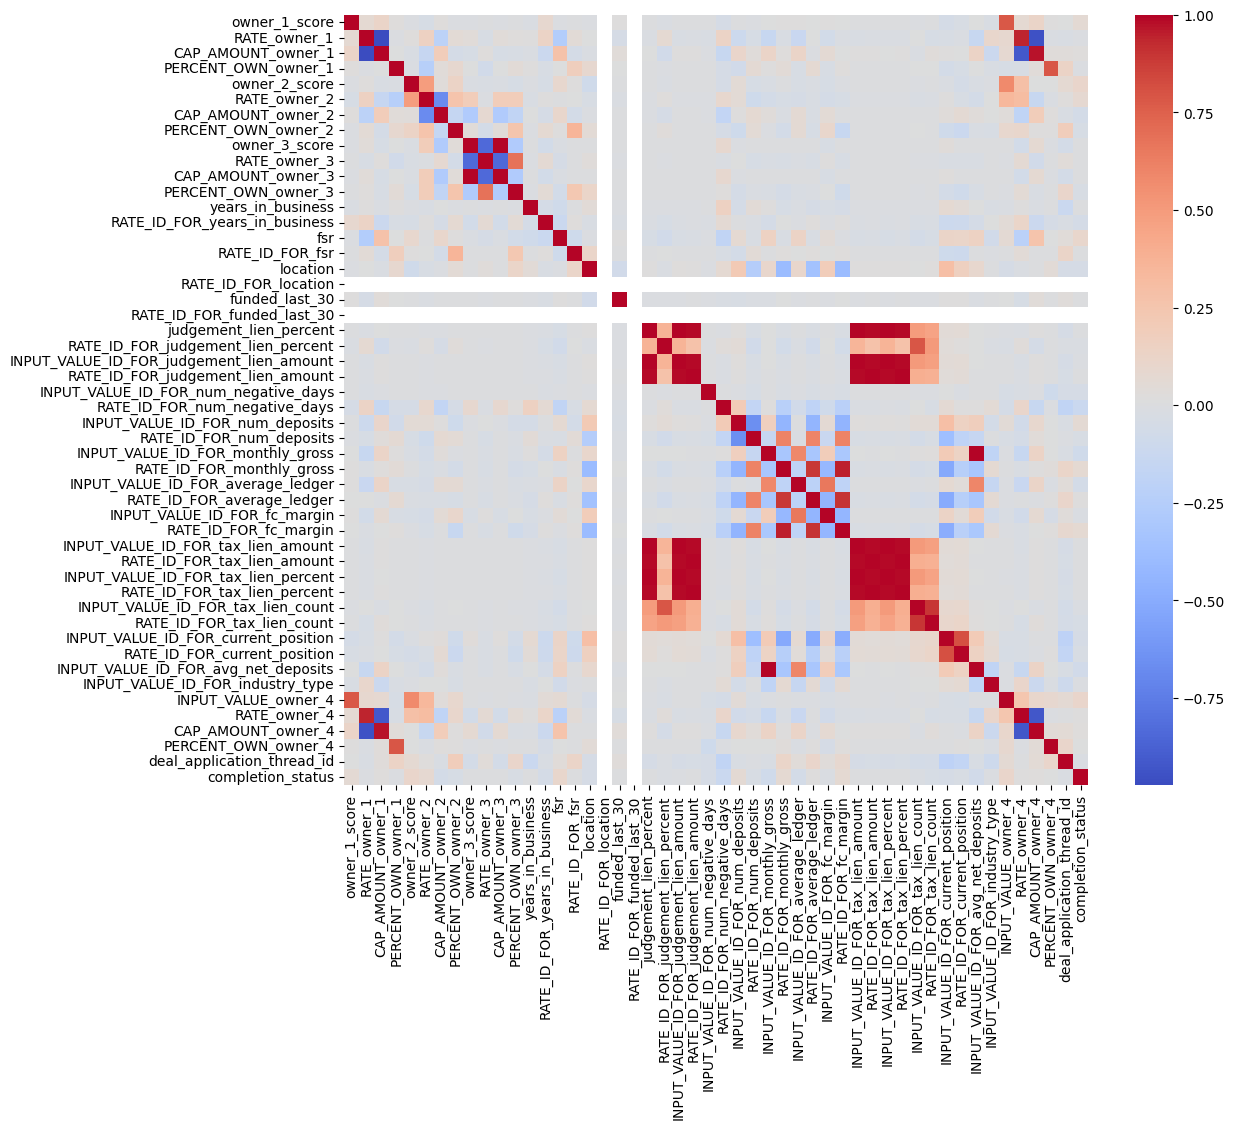

In [21]:
data = TrainDF.corr()
high_corr = data[data < 1]

plt.figure(figsize=(12, 10))  # increase figure size

sns.heatmap(data, cmap="coolwarm")
plt.show()

In [22]:
# dropping unused columns
TrainDF.drop(['RATE_ID_FOR_location'], axis=1, inplace=True)
TrainDF.drop(['RATE_ID_FOR_funded_last_30'], axis=1, inplace=True)

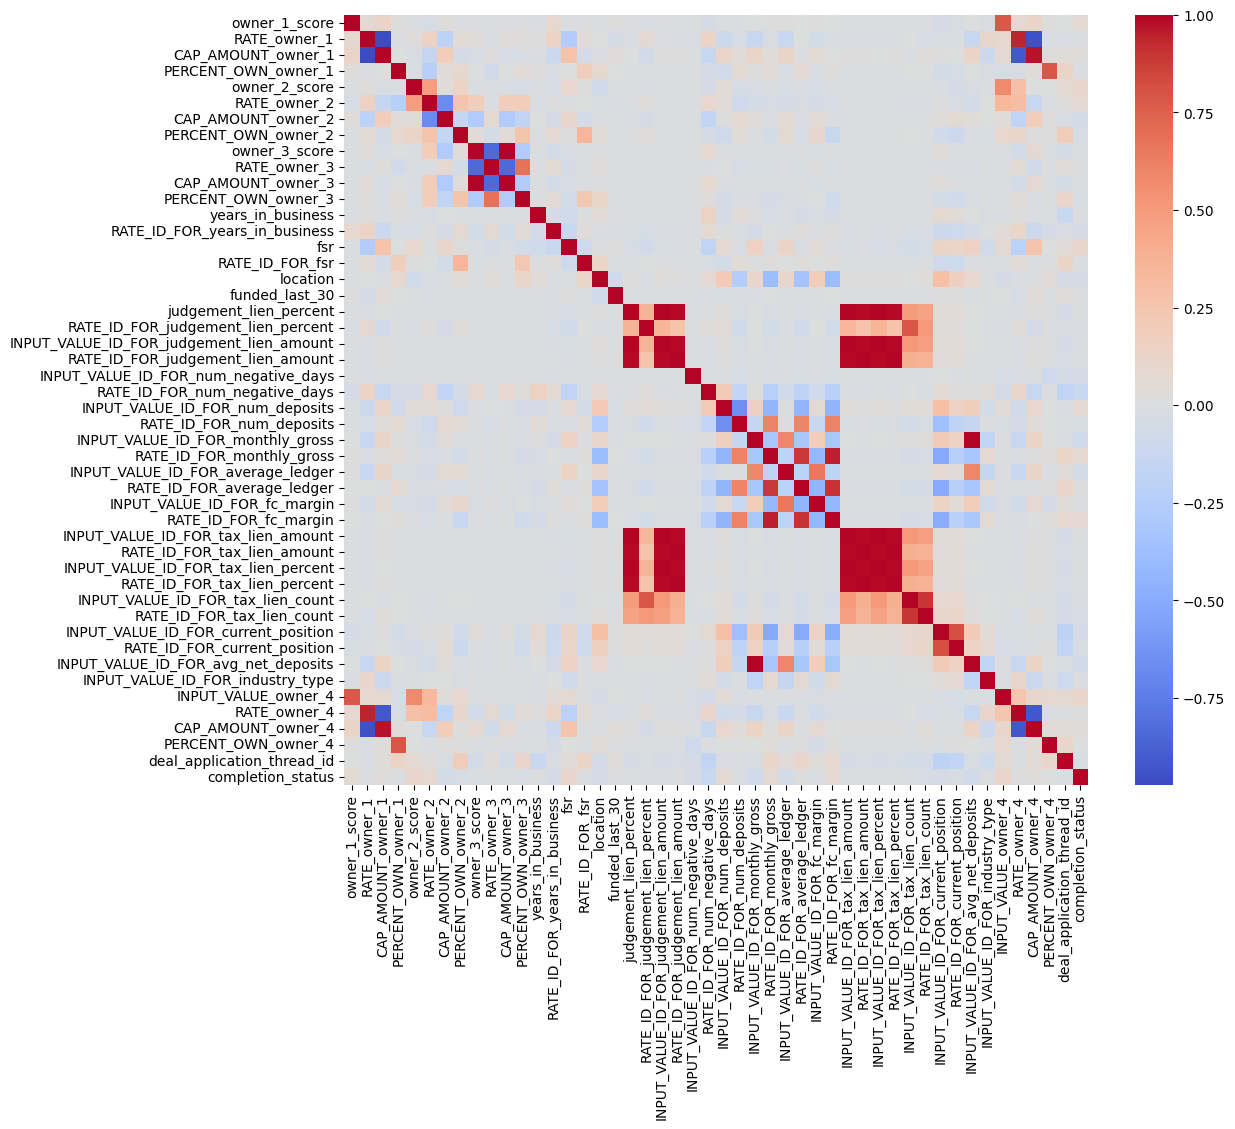

In [23]:
data = TrainDF.corr()
high_corr = data[data < 1]

plt.figure(figsize=(12, 10))  # increase figure size

sns.heatmap(data, cmap="coolwarm")
plt.show()

In [24]:
# Saving Pre-processed data in csv file for reviewing
TrainDF.to_csv('New_Train_Data.csv', index=False)

##### NoN

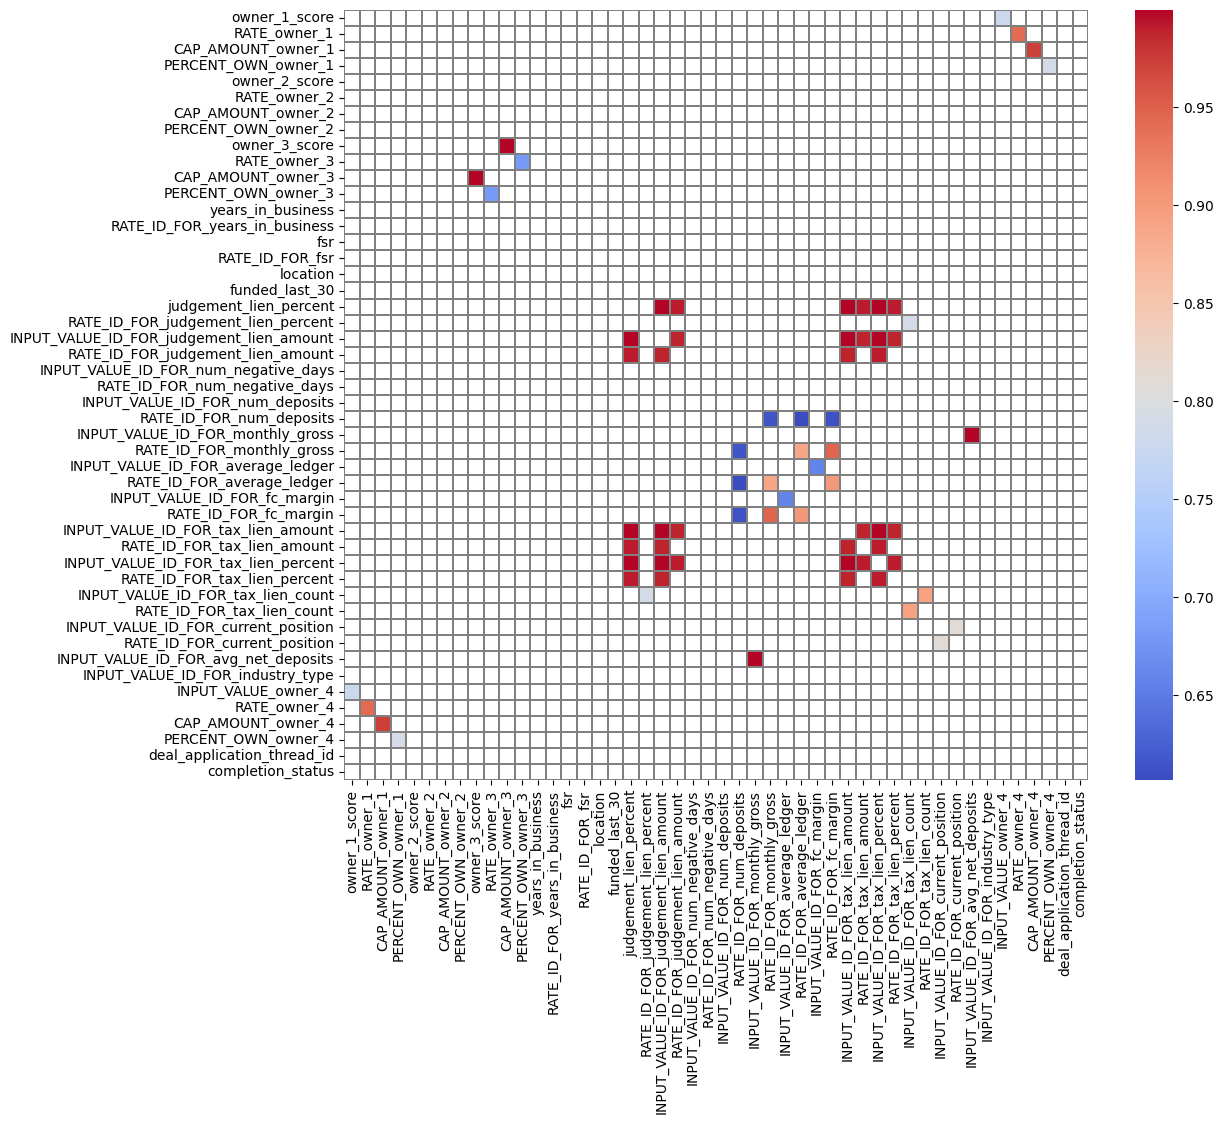

In [25]:
data = TrainDF.corr()
high_corr = np.logical_and(data > 0.6, data < 1)

plt.figure(figsize=(12, 10))

sns.heatmap(data[high_corr], cmap="coolwarm", linecolor="grey", linewidths=0.1)
plt.show()

In [26]:
high_corr_values = []
for row in high_corr.index:
    for col in high_corr.columns:
        if high_corr.loc[row, col]:
            high_corr_values.append(col)

high_corr_values = list(set(high_corr_values)) # remove duplicates
print('Lenght of the list =', len(high_corr_values))

print ('\nUseful Data Columns\n')
for item in high_corr_values:
    print(item)


Lenght of the list = 32

Useful Data Columns

INPUT_VALUE_ID_FOR_tax_lien_count
INPUT_VALUE_ID_FOR_tax_lien_amount
INPUT_VALUE_ID_FOR_tax_lien_percent
judgement_lien_percent
RATE_ID_FOR_judgement_lien_percent
INPUT_VALUE_ID_FOR_avg_net_deposits
RATE_ID_FOR_average_ledger
INPUT_VALUE_ID_FOR_monthly_gross
PERCENT_OWN_owner_1
RATE_ID_FOR_num_deposits
RATE_ID_FOR_monthly_gross
INPUT_VALUE_owner_4
RATE_owner_3
owner_1_score
RATE_ID_FOR_current_position
RATE_ID_FOR_tax_lien_amount
INPUT_VALUE_ID_FOR_judgement_lien_amount
PERCENT_OWN_owner_4
RATE_ID_FOR_tax_lien_count
CAP_AMOUNT_owner_4
RATE_owner_4
PERCENT_OWN_owner_3
RATE_ID_FOR_judgement_lien_amount
CAP_AMOUNT_owner_3
INPUT_VALUE_ID_FOR_current_position
owner_3_score
INPUT_VALUE_ID_FOR_average_ledger
CAP_AMOUNT_owner_1
INPUT_VALUE_ID_FOR_fc_margin
RATE_owner_1
RATE_ID_FOR_fc_margin
RATE_ID_FOR_tax_lien_percent


In [27]:
Train_cols = TrainDF.columns.tolist()

# Get a list of column names to keep (i.e., those in high_corr_values and the "target" column)
new_cols = [x for x in high_corr_values + ['completion_status'] if x in Train_cols]

FeaturesDF = TrainDF[new_cols]

In [28]:
FeaturesDF.head()

,INPUT_VALUE_ID_FOR_tax_lien_count,INPUT_VALUE_ID_FOR_tax_lien_amount,INPUT_VALUE_ID_FOR_tax_lien_percent,judgement_lien_percent,RATE_ID_FOR_judgement_lien_percent,INPUT_VALUE_ID_FOR_avg_net_deposits,RATE_ID_FOR_average_ledger,INPUT_VALUE_ID_FOR_monthly_gross,PERCENT_OWN_owner_1,RATE_ID_FOR_num_deposits,...,CAP_AMOUNT_owner_3,INPUT_VALUE_ID_FOR_current_position,owner_3_score,INPUT_VALUE_ID_FOR_average_ledger,CAP_AMOUNT_owner_1,INPUT_VALUE_ID_FOR_fc_margin,RATE_owner_1,RATE_ID_FOR_fc_margin,RATE_ID_FOR_tax_lien_percent,completion_status
0,0.0,0.0,0.0,0.0,0,0.00,1,0.00,100.0,3,...,105000.0,0.0,677.9,0.0000,150000.0,0.00,0,1,0,2
1,0.0,0.0,0.0,0.0,0,107027.25,0,107027.25,100.0,0,...,105000.0,1.0,677.9,36505.2275,150000.0,0.34,0,0,0,1
2,0.0,0.0,0.0,0.0,0,0.00,1,0.00,100.0,2,...,105000.0,0.0,677.9,0.0000,150000.0,0.00,0,1,0,0
3,0.0,0.0,0.0,0.0,0,0.00,1,0.00,100.0,3,...,105000.0,0.0,677.9,0.0000,150000.0,0.00,0,1,0,3
4,0.0,0.0,0.0,0.0,0,0.00,1,0.00,100.0,3,...,105000.0,0.0,677.9,0.0000,150000.0,0.00,0,1,0,1


### ***`Visualization`***

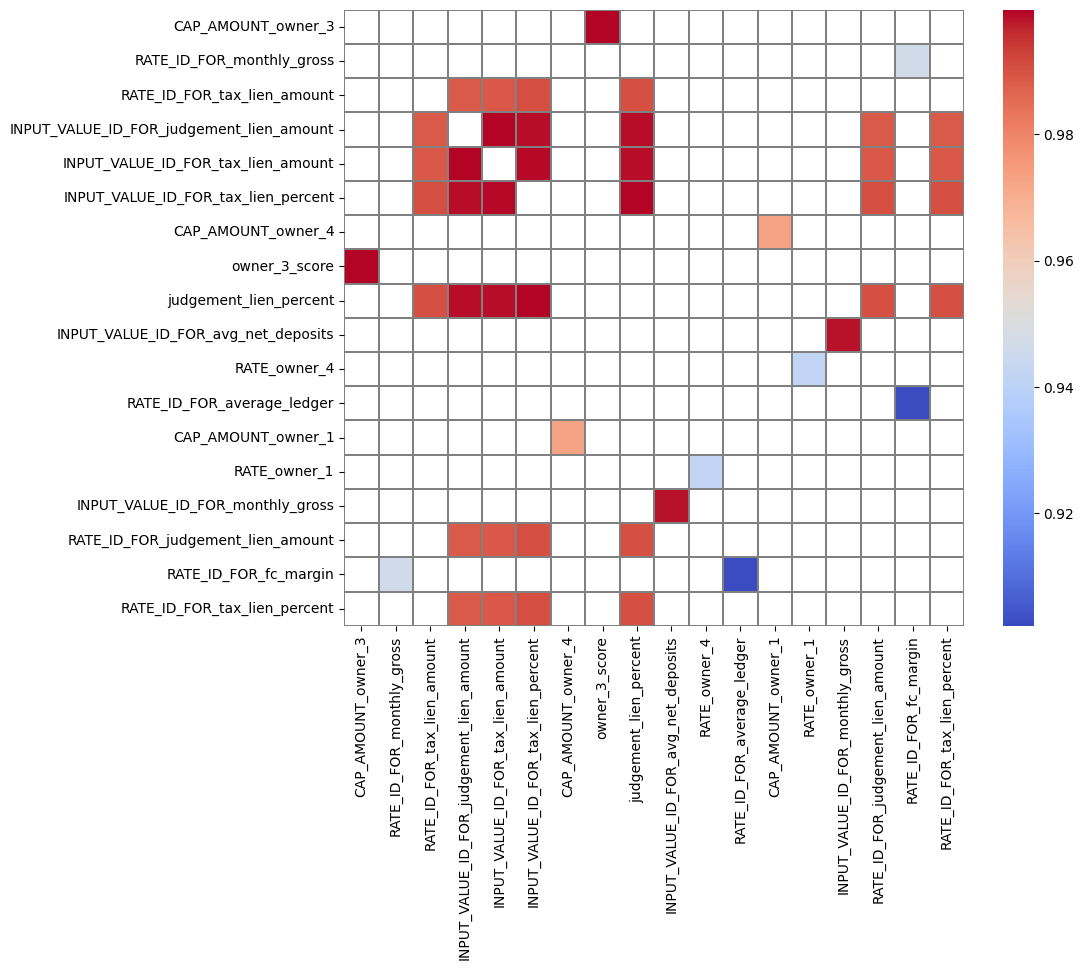

In [29]:
data = TrainDF.corr()
high_corr = np.logical_and(data > 0.9, data < 1)

high_corr_plt = []
for row in high_corr.index:
    for col in high_corr.columns:
        if high_corr.loc[row, col]:
            high_corr_plt.append(col)

high_corr_plt = list(set(high_corr_plt)) # remove duplicates

plt.figure(figsize=(10, 8))

sns.heatmap(data.loc[high_corr_plt, high_corr_plt][(data > 0.9) & (data < 1)], cmap="coolwarm", linecolor="grey", linewidths=0.1)
plt.show()


In [30]:
# de-encoding for visualization

status_map = {0: 'Default', 1: 'Paid in full', 2: 'Paid off with renewal', 3: 'Paid via discounted payoff'}

# Apply the mapping using the map() method
TrainDF['completion_status'] = TrainDF['completion_status'].map(status_map)


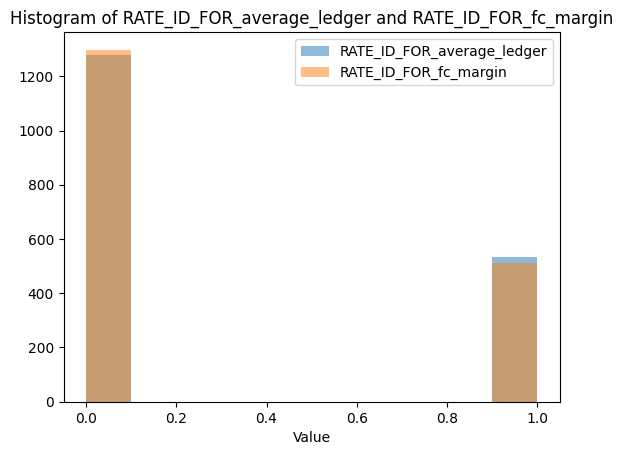

In [31]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the histogram for owner_3_score
ax.hist(TrainDF['RATE_ID_FOR_average_ledger'], alpha=0.5, label='RATE_ID_FOR_average_ledger')

# Plot the histogram for CAP_AMOUNT_owner_3
ax.hist(TrainDF['RATE_ID_FOR_fc_margin'], alpha=0.5, label='RATE_ID_FOR_fc_margin')

# Set the x-label and title
ax.set_xlabel('Value')
ax.set_title('Histogram of RATE_ID_FOR_average_ledger and RATE_ID_FOR_fc_margin')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

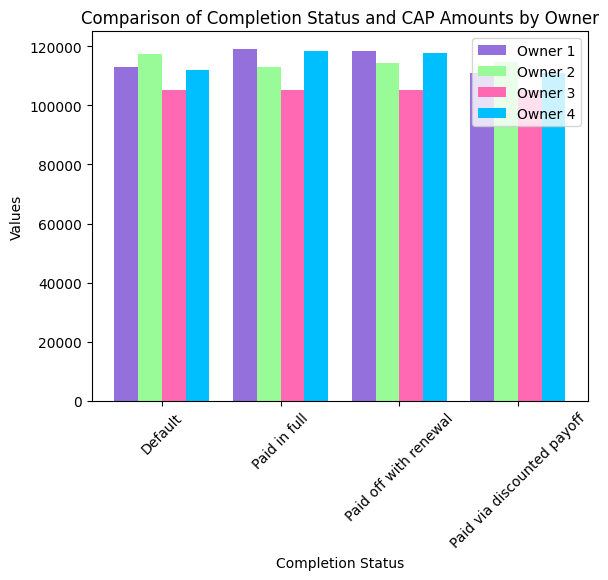

In [32]:

grouped = TrainDF.groupby('completion_status').mean()

# extract the values for each column
CAP_AMOUNT_owner_1_values = grouped['CAP_AMOUNT_owner_1']
CAP_AMOUNT_owner_2_values = grouped['CAP_AMOUNT_owner_2']
CAP_AMOUNT_owner_3_values = grouped['CAP_AMOUNT_owner_3']
CAP_AMOUNT_owner_4_values = grouped['CAP_AMOUNT_owner_4']

# create the bar chart
x_labels = grouped.index
x = range(len(x_labels))
width = 0.2

plt.bar(x, CAP_AMOUNT_owner_1_values, width=width, label='Owner 1', color='mediumpurple')
plt.bar([i + width for i in x], CAP_AMOUNT_owner_2_values, width=width, label='Owner 2', color='palegreen')
plt.bar([i + width*2 for i in x], CAP_AMOUNT_owner_3_values, width=width, label='Owner 3', color='hotpink')
plt.bar([i + width*3 for i in x], CAP_AMOUNT_owner_4_values, width=width, label='Owner 4', color='deepskyblue')

plt.xticks([i + width*1.5 for i in x], x_labels, rotation=45)
plt.xlabel('Completion Status')
plt.ylabel('Values')
plt.title('Comparison of Completion Status and CAP Amounts by Owner')

plt.legend()
plt.show()

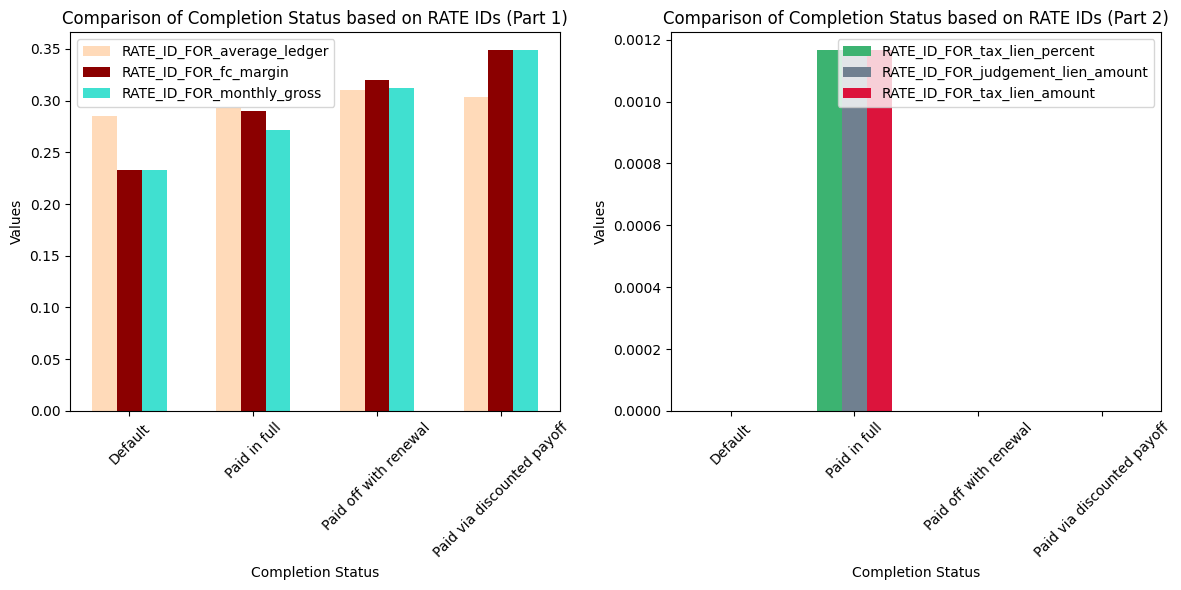

In [33]:
# group by completion status and calculate the mean for each RATE_ID
grouped = TrainDF.groupby('completion_status').mean()

# extract the values for each RATE_ID
RATE_ID_for_average_ledger_values = grouped['RATE_ID_FOR_average_ledger']
RATE_ID_for_fc_margin_values = grouped['RATE_ID_FOR_fc_margin']
RATE_ID_for_tax_lien_percent_values = grouped['RATE_ID_FOR_tax_lien_percent']
RATE_ID_for_monthly_gross_values = grouped['RATE_ID_FOR_monthly_gross']
RATE_ID_for_judgement_lien_amount_values = grouped['RATE_ID_FOR_judgement_lien_amount']
RATE_ID_for_tax_lien_amount_values = grouped['RATE_ID_FOR_tax_lien_amount']

# create the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# create the bar chart for RATE_ID_FOR_average_ledger, RATE_ID_FOR_fc_margin, RATE_ID_FOR_monthly_gross
ax1.bar(x, RATE_ID_for_average_ledger_values, width=width, label='RATE_ID_FOR_average_ledger', color='peachpuff')
ax1.bar([i + width for i in x], RATE_ID_for_fc_margin_values, width=width, label='RATE_ID_FOR_fc_margin', color='darkred')
ax1.bar([i + width*2 for i in x], RATE_ID_for_monthly_gross_values, width=width, label='RATE_ID_FOR_monthly_gross', color='turquoise')

ax1.set_xticks([i + width for i in x])
ax1.set_xticklabels(x_labels, rotation=45)
ax1.set_xlabel('Completion Status')
ax1.set_ylabel('Values')
ax1.set_title('Comparison of Completion Status based on RATE IDs (Part 1)')

ax1.legend()

# create the bar chart for RATE_ID_FOR_tax_lien_percent, RATE_ID_FOR_judgement_lien_amount, RATE_ID_FOR_tax_lien_amount
ax2.bar(x, RATE_ID_for_tax_lien_percent_values, width=width, label='RATE_ID_FOR_tax_lien_percent', color='mediumseagreen')
ax2.bar([i + width for i in x], RATE_ID_for_judgement_lien_amount_values, width=width, label='RATE_ID_FOR_judgement_lien_amount', color='slategrey')
ax2.bar([i + width*2 for i in x], RATE_ID_for_tax_lien_amount_values, width=width, label='RATE_ID_FOR_tax_lien_amount', color='crimson')

ax2.set_xticks([i + width for i in x])
ax2.set_xticklabels(x_labels, rotation=45)
ax2.set_xlabel('Completion Status')
ax2.set_ylabel('Values')
ax2.set_title('Comparison of Completion Status based on RATE IDs (Part 2)')

ax2.legend()

plt.tight_layout()
plt.show()


In [34]:
# re-encoding

# Define a dictionary to map the values
status_map = {'Default': 0, 'Paid in full': 1, 'Paid off with renewal': 2, 'Paid via discounted payoff': 3}

# Apply the mapping using the map() method
TrainDF['completion_status'] = TrainDF['completion_status'].map(status_map)


### ***`Modeling`***

In [35]:
TrainY = TrainDF['completion_status']
TrainX = TrainDF.drop(['completion_status'], axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(TrainX, TrainY, test_size=0.2, random_state=42)

##### ***1-XGBoostclassifier***

In [36]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.8],
    'max_depth': [3, 5, 7]
}

xgb_clf = xgb.XGBClassifier()
xgb_clf = GridSearchCV(xgb_clf, param_grid, cv=2,verbose=False)
xgb_clf.fit(X_train, Y_train)
y_pred= xgb_clf.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, y_pred)

print("Accuracy:", round(accuracy*100, 2), '%')
print("Precision:", round(precision*100, 2), '%')
print("Recall:", round(recall*100, 2), '%')
print("F1 score:", round(f1*100, 2), '%')
print("Confusion matrix:\n", conf_matrix)

Accuracy: 98.62 %
Precision: 98.96 %
Recall: 98.78 %
F1 score: 98.86 %
Confusion matrix:
 [[104   2   2   0]
 [  0 160   0   0]
 [  0   1  84   0]
 [  0   0   0   9]]


##### ***2-RandomForestClassifier***

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 25],
}

rfc = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=2, verbose=3)
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, y_pred)

print("Accuracy:", round(accuracy*100, 2), '%')
print("Precision:", round(precision*100, 2), '%')
print("Recall:", round(recall*100, 2), '%')
print("F1 score:", round(f1*100, 2), '%')
print("Confusion matrix:\n", conf_matrix)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .....max_depth=5, n_estimators=100;, score=0.570 total time=   0.1s
[CV 2/2] END .....max_depth=5, n_estimators=100;, score=0.606 total time=   0.1s
[CV 1/2] END .....max_depth=5, n_estimators=200;, score=0.573 total time=   0.2s
[CV 2/2] END .....max_depth=5, n_estimators=200;, score=0.604 total time=   0.2s
[CV 1/2] END .....max_depth=5, n_estimators=300;, score=0.573 total time=   0.4s
[CV 2/2] END .....max_depth=5, n_estimators=300;, score=0.604 total time=   0.3s
[CV 1/2] END ....max_depth=10, n_estimators=100;, score=0.801 total time=   0.1s
[CV 2/2] END ....max_depth=10, n_estimators=100;, score=0.794 total time=   0.1s
[CV 1/2] END ....max_depth=10, n_estimators=200;, score=0.794 total time=   0.3s
[CV 2/2] END ....max_depth=10, n_estimators=200;, score=0.796 total time=   0.2s
[CV 1/2] END ....max_depth=10, n_estimators=300;, score=0.789 total time=   0.4s
[CV 2/2] END ....max_depth=10, n_estimators=300;,

##### ***3-GradientBoostingClassifier***

In [38]:
param_grid = {
    'learning_rate': [0.01, 0.8],
    'n_estimators': [100, 200]
}

gb_clf = GradientBoostingClassifier()
gb_clf_grid = GridSearchCV(gb_clf, param_grid, cv=2, verbose=3)
gb_clf_grid.fit(X_train, Y_train)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, y_pred)

print("Accuracy:", round(accuracy*100, 2), '%')
print("Precision:", round(precision*100, 2), '%')
print("Recall:", round(recall*100, 2), '%')
print("F1 score:", round(f1*100, 2), '%')
print("Confusion matrix:\n", conf_matrix)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END learning_rate=0.01, n_estimators=100;, score=0.609 total time=   1.0s
[CV 2/2] END learning_rate=0.01, n_estimators=100;, score=0.593 total time=   1.0s
[CV 1/2] END learning_rate=0.01, n_estimators=200;, score=0.678 total time=   2.1s
[CV 2/2] END learning_rate=0.01, n_estimators=200;, score=0.735 total time=   1.9s
[CV 1/2] END learning_rate=0.8, n_estimators=100;, score=0.907 total time=   0.9s
[CV 2/2] END learning_rate=0.8, n_estimators=100;, score=0.912 total time=   0.9s
[CV 1/2] END learning_rate=0.8, n_estimators=200;, score=0.907 total time=   1.8s
[CV 2/2] END learning_rate=0.8, n_estimators=200;, score=0.910 total time=   1.7s
Accuracy: 94.75 %
Precision: 93.88 %
Recall: 95.59 %
F1 score: 94.62 %
Confusion matrix:
 [[ 98   7   3   0]
 [  1 156   2   1]
 [  1   4  80   0]
 [  0   0   0   9]]


##### ***4-CatBoost***

In [39]:
param_grid = {
    'iterations': [50, 300],
    'learning_rate': [0.01, 0.3],
    'depth': [3, 5, 7],
}

cbc = CatBoostClassifier(random_state=42)
cbc = GridSearchCV(cbc, param_grid, cv=2, verbose=3, n_jobs=-1)
cbc.fit(X_train, Y_train, verbose=False)
y_pred = cbc.predict(X_test)


accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, y_pred)

print("Accuracy:", round(accuracy*100, 2), '%')
print("Precision:", round(precision*100, 2), '%')
print("Recall:", round(recall*100, 2), '%')
print("F1 score:", round(f1*100, 2), '%')
print("Confusion matrix:\n", conf_matrix)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Accuracy: 96.41 %
Precision: 97.42 %
Recall: 97.17 %
F1 score: 97.28 %
Confusion matrix:
 [[101   7   0   0]
 [  1 156   3   0]
 [  1   1  83   0]
 [  0   0   0   9]]


##### ***5-KNN***

In [40]:
# Define the hyperparameters to tune
param_grid = {'n_neighbors': [3, 9],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                           weights=best_params['weights'],
                           algorithm=best_params['algorithm'],
                           p=best_params['p'])

knn.fit(X_train, Y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, y_pred)

print("Accuracy:", round(accuracy*100, 2), '%')
print("Precision:", round(precision*100, 2), '%')
print("Recall:", round(recall*100, 2), '%')
print("F1 score:", round(f1*100, 2), '%')
print("Confusion matrix:\n", conf_matrix)


Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 91.44 %
Precision: 93.04 %
Recall: 93.34 %
F1 score: 93.13 %
Confusion matrix:
 [[ 93  10   5   0]
 [  4 149   7   0]
 [  4   1  80   0]
 [  0   0   0   9]]


##### ***6-DecisionTree***

In [41]:
from sklearn.tree import DecisionTreeClassifier


# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 20 ,50]}
 
# Create a Decision Tree Classifier object
DT = DecisionTreeClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=DT, param_grid=param_grid, cv=50, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Use the best hyperparameters to create a new Decision Tree Classifier object
DT_best = DecisionTreeClassifier(criterion=best_params['criterion'],
                                  max_depth=best_params['max_depth'])

# Train the classifier on the training data
DT_best.fit(X_train, Y_train)

# Make predictions on the testing data
y_pred = DT_best.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, y_pred)

print("Accuracy:", round(accuracy*100, 2), '%')
print("Precision:", round(precision*100, 2), '%')
print("Recall:", round(recall*100, 2), '%')
print("F1 score:", round(f1*100, 2), '%')
print("Confusion matrix:\n", conf_matrix)


Accuracy: 92.27 %
Precision: 86.9 %
Recall: 94.61 %
F1 score: 90.02 %
Confusion matrix:
 [[100   6   2   0]
 [  9 143   5   3]
 [  1   1  82   1]
 [  0   0   0   9]]


### ***`Evaluation`***

##### ***Best Model: XGBoostclassifier***

In [42]:
TrainY = TrainDF['completion_status']
TrainX = TrainDF.drop(['completion_status'], axis = 1)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.8],
    'max_depth': [3, 5, 7]
}

xgb_clf = xgb.XGBClassifier()
xgb_clf = GridSearchCV(xgb_clf, param_grid, cv=2,verbose=False)
xgb_clf.fit(TrainX, TrainY)
y_pred = xgb_clf.predict(TrainX)

### ***`Test Script`***

In [43]:
TestDF = pd.read_csv("test.csv") 

In [44]:
# use only trained columns
Train_cols = TrainDF.columns.tolist()
TestDF = TestDF.reindex(columns= Train_cols)

In [45]:
column_label = TestDF.columns
mean_name = Train_mean.index
mean_value = Train_mean.values
comm_name = common_df.columns
comm_value = common_df.values

# fill nulls with mean
for col in column_label:
    data_type = TestDF[col].dtype
    if data_type != object:
        # Check if the current column in TestDF matches any column in Train_mean
        if col in mean_name:
            # Find the index of the current column in Train_mean
            i = mean_name.get_loc(col)
            # Fill null values with the mean of the corresponding column in Train_mean
            TestDF[col].fillna(mean_value[i], inplace=True)

# fill nulls with commons
for col in column_label:
        if col in comm_name:
            # Find the index of the current column in Train_mean
            j = comm_name.get_loc(col)
            # Fill null values with the common value in TestDF
            TestDF[col].fillna(comm_value[0][j], inplace=True)

# encoding 

# loop through the columns of the test data
for col in TestDF.columns:
    # check if the column is categorical
    if TestDF[col].dtype == object:
        # get the encoding data for the column
        enc_data = encoding_data.get(col)
        # if encoding data exists, encode the column using the transform() method
        if enc_data is not None:
            TestDF[col] = TestDF[col].apply(lambda x: enc_data.get(x, -1))

In [46]:
TestDF.head()

,owner_1_score,RATE_owner_1,CAP_AMOUNT_owner_1,PERCENT_OWN_owner_1,owner_2_score,RATE_owner_2,CAP_AMOUNT_owner_2,PERCENT_OWN_owner_2,owner_3_score,RATE_owner_3,...,INPUT_VALUE_ID_FOR_current_position,RATE_ID_FOR_current_position,INPUT_VALUE_ID_FOR_avg_net_deposits,INPUT_VALUE_ID_FOR_industry_type,INPUT_VALUE_owner_4,RATE_owner_4,CAP_AMOUNT_owner_4,PERCENT_OWN_owner_4,deal_application_thread_id,completion_status
0,505.0,2,35000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,0.0,0,109106.000000,2,505.0,2,35000.0,100.0,1977.0,2
1,598.0,1,100000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,1.0,0,153910.692500,2,598.0,1,100000.0,100.0,4538.0,1
2,690.0,0,150000.0,33.3,717.000000,0,150000.00000,33.300000,677.9,0,...,1.0,0,391481.250000,2,703.0,0,150000.0,66.6,2131.0,0
3,672.0,0,150000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,2.0,1,145602.428571,2,672.0,0,150000.0,100.0,5598.0,2
4,634.0,0,150000.0,100.0,1087.990654,0,114529.70297,35.180695,677.9,0,...,1.0,0,22445.000000,3,634.0,0,150000.0,100.0,765.0,2


In [47]:
TestDF.to_csv('New_Test_Data.csv', index=False)

In [48]:
TestDF.isnull().sum()*100/TestDF.shape[0]

owner_1_score                               0.0
RATE_owner_1                                0.0
CAP_AMOUNT_owner_1                          0.0
PERCENT_OWN_owner_1                         0.0
owner_2_score                               0.0
RATE_owner_2                                0.0
CAP_AMOUNT_owner_2                          0.0
PERCENT_OWN_owner_2                         0.0
owner_3_score                               0.0
RATE_owner_3                                0.0
CAP_AMOUNT_owner_3                          0.0
PERCENT_OWN_owner_3                         0.0
years_in_business                           0.0
RATE_ID_FOR_years_in_business               0.0
fsr                                         0.0
RATE_ID_FOR_fsr                             0.0
location                                    0.0
funded_last_30                              0.0
judgement_lien_percent                      0.0
RATE_ID_FOR_judgement_lien_percent          0.0
INPUT_VALUE_ID_FOR_judgement_lien_amount

In [49]:
TestY = TestDF['completion_status']
TestX = TestDF.drop(['completion_status'], axis = 1)

y_pred= xgb_clf.predict(TestX)

accuracy = accuracy_score(TestY, y_pred)
precision = precision_score(TestY, y_pred, average='macro')
recall = recall_score(TestY, y_pred, average='macro')
f1 = f1_score(TestY, y_pred, average='macro')
conf_matrix = confusion_matrix(TestY, y_pred)

print("Accuracy:", round(accuracy*100, 2), '%')
print("Precision:", round(precision*100, 2), '%')
print("Recall:", round(recall*100, 2), '%')
print("F1 score:", round(f1*100, 2), '%')
print("Confusion matrix:\n", conf_matrix)

Accuracy: 98.02 %
Precision: 98.43 %
Recall: 98.47 %
F1 score: 98.45 %
Confusion matrix:
 [[52  1  0  0]
 [ 0 96  2  0]
 [ 0  1 45  0]
 [ 0  0  0  5]]
